In [1]:
%matplotlib inline

# Pandas querying and metadata with Epochs objects

`
Authors: Chris Holdgraf <choldgraf@gmail.com>
         Jona Sassenhagen <jona.sassenhagen@gmail.com>
         Eric Larson <larson.eric.d@gmail.com>
         Alex Gramfort <alexandre.gramfort@inria.fr>
`

This notebook demonstrates how to use Epochs with metadata.
This allows to use [pandas-style string querying](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) and also to keep
all metadata aligned with the epochs.

Sometimes you may have a complex trial structure that cannot be easily
summarized as a set of unique integers. In this case, it may be useful to use
the ``metadata`` attribute of `mne.Epochs` objects. This must be a
`pandas.DataFrame` where each row corresponds to an epoch, and each
column corresponds to a metadata attribute of each epoch. Columns must
contain either strings, ints, or floats.

In this dataset, subjects were presented with individual words
on a screen, and the EEG activity in response to each word was recorded.
We know which word was displayed in each epoch, as well as
extra information about the word (e.g., word frequency).

See [reference paper](https://hal.archives-ouvertes.fr/hal-01432349/document):

    Dufau, S., Grainger, J., Midgley, KJ., Holcomb, PJ.
    A thousand words are worth a picture: Snapshots of printed-word processing
    in an event-related potential megastudy. Psychological Science, 2015

## Loading the data

First we'll load the data. If metadata exists for an `mne.Epochs`
fif file, it will automatically be loaded in the ``metadata`` attribute.

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the internet
path = mne.datasets.kiloword.data_path() + '/kword_metadata-epo.fif'
epochs = mne.read_epochs(path)

In [3]:
# The metadata exists as a Pandas DataFrame
type(epochs.metadata)

pandas.core.frame.DataFrame

In [4]:
# We have one set of metadata for each epoch:
len(epochs), len(epochs.metadata)

(960, 960)

In [5]:
# Inspect the content by displaying the first 5 rows
print(epochs.metadata.head(5))

   WORD  Concreteness  WordFrequency  OrthographicDistance  NumberOfLetters  \
0  film          5.45       3.189490                  1.75              4.0   
1  cent          5.90       3.700704                  1.35              4.0   
2  shot          4.60       2.858537                  1.20              4.0   
3  cold          3.70       3.454540                  1.15              4.0   
4  main          3.00       3.539076                  1.35              4.0   

   BigramFrequency  ConsonantVowelProportion  VisualComplexity  
0           343.25                      0.75         55.783710  
1           546.75                      0.75         63.141553  
2           484.75                      0.75         64.600033  
3          1095.25                      0.75         63.657457  
4           686.00                      0.50         68.945661  


As we have a dataframe one can do standard Pandas manipulations:

In [6]:
epochs.metadata[['WORD', 'Concreteness']].head(5)  # take only 2 columns

,WORD,Concreteness
0,film,5.45
1,cent,5.90
2,shot,4.60
3,cold,3.70
4,main,3.00


In [7]:
epochs.metadata[['WORD', 'Concreteness']].sort_values(by="Concreteness", ascending=False).head(5)

,WORD,Concreteness
126,violin,6.90
128,toilet,6.75
361,pencil,6.70
253,milk,6.70
741,tree,6.70


In [8]:
epochs.metadata.groupby('NumberOfLetters').count()[['WORD']]  # Nb. of word of each length

,WORD
NumberOfLetters,
4.0,192
5.0,192
6.0,192
7.0,192
8.0,192


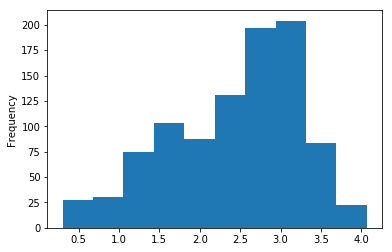

In [9]:
epochs.metadata['WordFrequency'].plot('hist')  # histogram of word frequencies

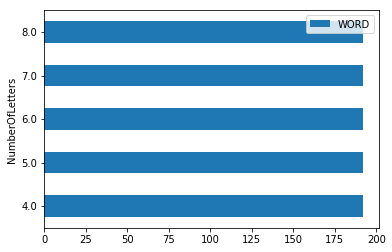

In [10]:
epochs.metadata.groupby('NumberOfLetters').count()[['WORD']].plot(kind='barh')  # Plot nb. of word of each length

## Let's use seaborn to make publication ready plots:

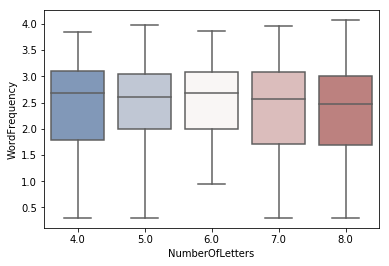

In [11]:
import seaborn as sns

sns.boxplot(x="NumberOfLetters", y="WordFrequency", data=epochs.metadata,
            whis="range", palette="vlag")

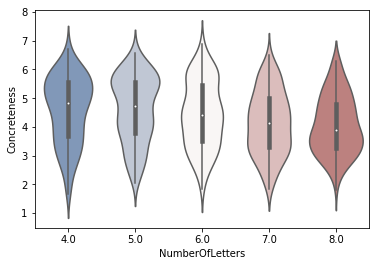

In [12]:
sns.violinplot(x="NumberOfLetters", y="Concreteness", data=epochs.metadata,
               palette="vlag")

### My first pandas query:

In [13]:
epochs.metadata.query('Concreteness < 4.5 and NumberOfLetters < 5').head(5)

,WORD,Concreteness,WordFrequency,OrthographicDistance,NumberOfLetters,BigramFrequency,ConsonantVowelProportion,VisualComplexity
3,cold,3.70,3.454540,1.15,4.0,1095.25,0.75,63.657457
4,main,3.00,3.539076,1.35,4.0,686.00,0.50,68.945661
8,idea,1.95,3.688420,1.90,4.0,201.75,0.25,70.667496
9,love,1.80,3.607026,1.15,4.0,337.25,0.50,61.394212
10,role,3.35,3.322839,1.10,4.0,536.25,0.50,57.463779


<div class="alert alert-success">
    <b>Exercise</b>:
     <ul>
    <li>How many words have a WordFrequency higher than 4 and a NumberOfLetters of 5</li>
    <li>What is the distribution of number of letters among the words having a VisualComplexity higher than 65.</li>
    <li>Represent this distribution with a pie chart.</li>
    </ul>
</div>

In [14]:
# TODO


# From Epochs slicing to pandas queries

Let's first use standard epochs indexing:

In [15]:
epochs[0]  # get first epoch

<EpochsFIF  |   1 events (all good), -0.1 - 0.92 sec, baseline off, ~118 kB, data loaded, with metadata,
 'film': 1>

In [16]:
epochs[:10]  # get first 10 epoch

<EpochsFIF  |   10 events (all good), -0.1 - 0.92 sec, baseline off, ~640 kB, data loaded, with metadata,
 'case': 1
 'cent': 1
 'cold': 1
 'film': 1
 'idea': 1
 'land': 1
 'love': 1
 'main': 1
 'poet': 1
 'shot': 1>

In [17]:
epochs['loft']  # get epoch based on event_id

<EpochsFIF  |   1 events (all good), -0.1 - 0.92 sec, baseline off, ~118 kB, data loaded, with metadata,
 'loft': 1>

Now when we have some metadata attached to the epochs one can directly query the epochs
to select subsets of Epochs. This uses the Pandas :meth:`pandas.DataFrame.query` method under the hood.
Any valid query string will work. Below we'll make two plots to compare
between them:

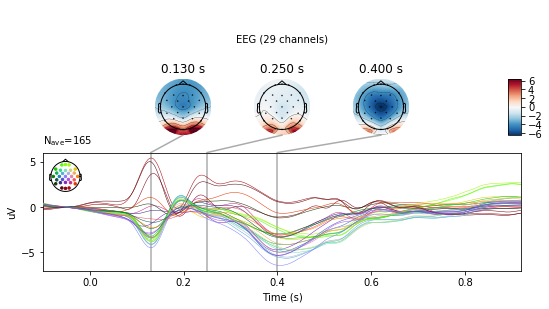

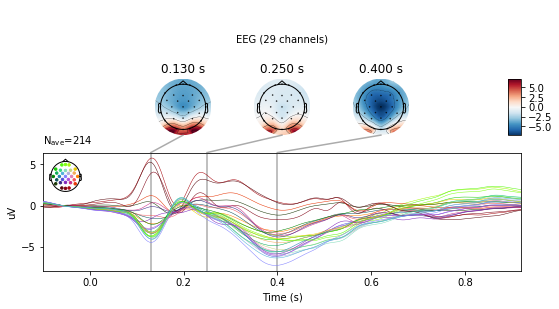

In [18]:
evoked1 = epochs['Concreteness < 5 and WordFrequency < 2'].average()
evoked2 = epochs['Concreteness > 5 and WordFrequency > 2'].average()

evoked1.plot_joint(times=[0.13, 0.25, 0.4])
evoked2.plot_joint(times=[0.13, 0.25, 0.4]);

Next we'll choose a subset of words to keep.



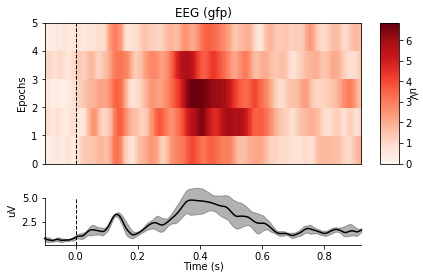

[<Figure size 432x288 with 3 Axes>]

In [19]:
words = ['film', 'cent', 'shot', 'cold', 'main']
epochs['WORD in {}'.format(words)].plot_image()

### Advanced

Below we'll show a more involved example that leverages the metadata
of each epoch. We'll create a new column in our metadata object and use
it to generate averages for many subsets of trials.

In [20]:
# Create two new metadata columns
metadata = epochs.metadata
is_concrete = metadata["Concreteness"] > metadata["Concreteness"].median()
metadata["is_concrete"] = np.where(is_concrete, 'Concrete', 'Abstract')
is_long = metadata["NumberOfLetters"] > 5
metadata["is_long"] = np.where(is_long, 'Long', 'Short')
epochs.metadata = metadata
epochs.metadata.head(5)

,WORD,Concreteness,WordFrequency,OrthographicDistance,NumberOfLetters,BigramFrequency,ConsonantVowelProportion,VisualComplexity,is_concrete,is_long
0,film,5.45,3.189490,1.75,4.0,343.25,0.75,55.783710,Concrete,Short
1,cent,5.90,3.700704,1.35,4.0,546.75,0.75,63.141553,Concrete,Short
2,shot,4.60,2.858537,1.20,4.0,484.75,0.75,64.600033,Concrete,Short
3,cold,3.70,3.454540,1.15,4.0,1095.25,0.75,63.657457,Abstract,Short
4,main,3.00,3.539076,1.35,4.0,686.00,0.50,68.945661,Abstract,Short


Now we can quickly extract (and plot) subsets of the data. For example, to
look at words split by word length and concreteness:



In [21]:
query = "is_long == '{0}' & is_concrete == '{1}'"
evokeds = dict()
for concreteness in ("Concrete", "Abstract"):
    for length in ("Long", "Short"):
        subset = epochs[query.format(length, concreteness)]
        evokeds["/".join((concreteness, length))] = subset.average()

evokeds.keys()

dict_keys(['Concrete/Long', 'Concrete/Short', 'Abstract/Long', 'Abstract/Short'])

In [22]:
type(evokeds['Concrete/Long'])  # one evoked

mne.evoked.EvokedArray

In [23]:
evokeds['Concrete/Long'].nave  # obtained by averaging 252 epochs

252

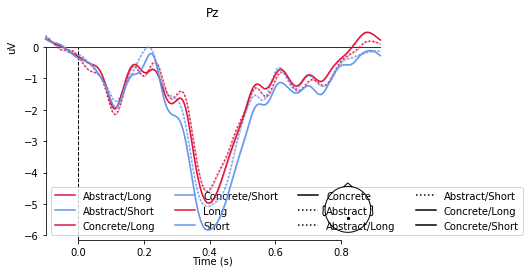

In [24]:
# For the actual visualisation, we store a number of shared parameters.
style_plot = dict(
    colors={"Long": "Crimson", "Short": "Cornflowerblue"},
    linestyles={"Concrete": "-", "Abstract": ":"},
    split_legend=True,
    ci=.68,  # confidence interval
    show_sensors='lower right',
    show_legend='lower left',
    truncate_yaxis="max_ticks",
    picks=epochs.ch_names.index("Pz"),
)

fig, ax = plt.subplots(figsize=(6, 4))
mne.viz.plot_compare_evokeds(evokeds, axes=ax, **style_plot)
plt.show()

In order to be able to plot confidence intervals I need the full set of epochs:

In [25]:
query = "is_long == '{0}' & is_concrete == '{1}'"
evokeds = dict()
for concreteness in ("Concrete", "Abstract"):
    for length in ("Long", "Short"):
        subset = epochs[query.format(length, concreteness)]
        evokeds["/".join((concreteness, length))] = list(subset.iter_evoked())

evokeds.keys()

dict_keys(['Concrete/Long', 'Concrete/Short', 'Abstract/Long', 'Abstract/Short'])

In [26]:
type(evokeds['Concrete/Long']), type(evokeds['Concrete/Long'][0])  # list of evoked

(list, mne.evoked.EvokedArray)

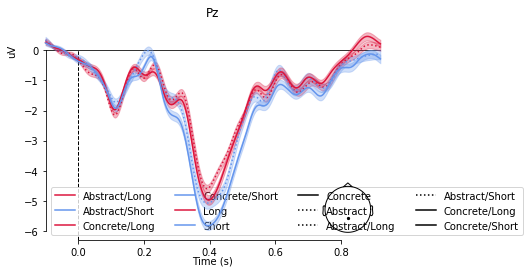

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
mne.viz.plot_compare_evokeds(evokeds, axes=ax, **style_plot)
plt.show()

Let's now compare words which are 4, 5, 6, 7 or 8 letters long:

In [28]:
letters = epochs.metadata["NumberOfLetters"].unique().astype(int).astype(str)
letters

array(['4', '5', '6', '7', '8'], dtype='<U21')

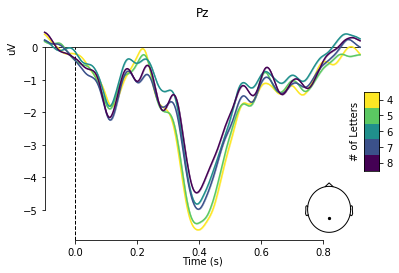

In [29]:
evokeds = dict()
for n_letters in letters:
    evokeds[n_letters] = epochs["NumberOfLetters == " + n_letters].average()

style_plot["colors"] = {n_letters: int(n_letters)
                        for n_letters in letters}
style_plot["cmap"] = ("# of Letters", "viridis_r")
del style_plot['linestyles']

fig, ax = plt.subplots(figsize=(6, 4))
mne.viz.plot_compare_evokeds(evokeds, axes=ax, **style_plot)
plt.show()

And finally, for the interaction between concreteness and continuous length
in letters:



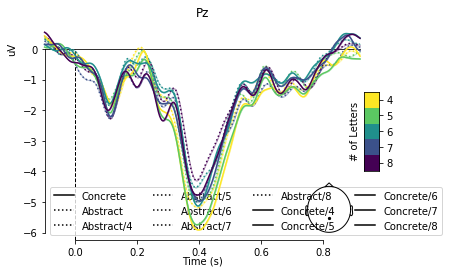

In [30]:
evokeds = dict()
query = "is_concrete == '{0}' & NumberOfLetters == {1}"
for concreteness in ("Concrete", "Abstract"):
    for n_letters in letters:
        subset = epochs[query.format(concreteness, n_letters)]
        evokeds["/".join((concreteness, n_letters))] = subset.average()

style_plot["linestyles"] = {"Concrete": "-", "Abstract": ":"}

fig, ax = plt.subplots(figsize=(6, 4))
mne.viz.plot_compare_evokeds(evokeds, axes=ax, **style_plot)
plt.show()

<div class="alert alert-info"><h4>Note</h4><p>Creating an mne.Epochs object with metadata is done by passing
   a pandas.DataFrame to the ``metadata`` kwarg as follows:</p></div>

In [31]:
data = epochs.get_data()
metadata = epochs.metadata.copy()
epochs_new = mne.EpochsArray(data, epochs.info, metadata=metadata)